In [1]:
# Imports
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
import json
import uuid

from qsi.coordinator import Coordinator
from qsi.state import State, StateProp

plt.style.use('paper.mplstyle')

In [2]:
def photon_number_projectors(dim_e,dim_l):
    ''' Returns a photon number projector to be applied to the early and late states in the joint e x l space.
    
     Args:
        dim_e (int): Dimension of the early state
        dim_l (int): Dimension of the late state

    Returns:
        np.ndarray: The number operator on the early state
        np.ndarray: The number operator on the late state

    '''
    a_e  = np.zeros((dim_e, dim_e))
    for i in range(0,dim_e-1):
        a_e[i,i+1] = np.sqrt(i+1)
    a_dagger_e = a_e.conj().T
    n_hat_e = a_dagger_e@a_e  
    
    a_l  = np.zeros((dim_l, dim_l))
    for i in range(0,dim_l-1):
        a_l[i,i+1] = np.sqrt(i+1)
    a_dagger_l = a_l.conj().T
    n_hat_l = a_dagger_l@a_l  

    n_hat_e = np.kron(n_hat_e, np.eye(dim_l))
    n_hat_l = np.kron(np.eye(dim_e), n_hat_l)

    return n_hat_e, n_hat_l


In [3]:
#start the coordinator
coordinator = Coordinator(port=20002)

#Add the memory and the coherent source
mem = coordinator.register_component(module="memory.py", runtime="python")
cs = coordinator.register_component(module="coherent_source.py", runtime = "python")

# Run the coordinator process
coordinator.run()

{'storage_time': {'value': None, 'type': 'number'}, 'memory_type': {'value': None, 'type': 'string'}, 'memory_truncation': {'value': None, 'type': 'number'}, 't_in': {'value': None, 'type': 'number'}, 't_out': {'value': None, 'type': 'number'}, 'k_e': {'value': None, 'type': 'number'}, 'k_l': {'value': None, 'type': 'number'}, 'nB_e': {'value': None, 'type': 'number'}, 'nB_l': {'value': None, 'type': 'number'}}
{'alpha': {'value': None, 'type': 'complex'}}


In [4]:
#define the memory paramters
storage_time = 0e-6            #s
mem_type = 'Lambda895'         
trunc = 5

In [6]:
# Set the memory paramters.
mem.set_param("storage_time", storage_time)
mem.set_param("memory_type", mem_type)
mem.set_param("memory_truncation",int(trunc))
mem.send_params()

# Initialise the internal state of the memory
mem_state_bs = mem.state_init()[0]

# Set the coherent source paramters
cs.set_param("alpha", 1+0j)
cs.send_params()


# define properties of the input state (early state)
state_early_prop = StateProp(
    state_type="light",
    truncation=trunc,
    wavelength=895,
    polarization='H',
    uuid="early",
    bandwidth =0.5e9 

)
# make the early state (vaccum state)
state_early = State(state_early_prop)

# Generate coherent source operators
response, operators = cs.channel_query(
state_early, {"input": state_early_prop.uuid}
)

# apply coherent source operators
state_early.apply_kraus_operators(operators, [state_early_prop])

# create a joint state, consisting of just the early state
whole_state =  state_early

# Add the internal state of the memory to make a joint state e x s
whole_state.join(mem_state_bs)

# Generate the memory storage operators. 
response, operators = mem.channel_query(
    whole_state, {"input": state_early_prop.uuid, 'op_type': 'storage'}
)

# Apply memory storage operators.
whole_state.apply_kraus_operators(operators, whole_state.get_all_props(response["kraus_state_indices"]))


# define the properties of the late state 
state_late_prop = StateProp(
    state_type="light",
    truncation=trunc,
    wavelength=895,
    polarization='H',
    uuid="late",
    bandwidth =0.5e9

)
# create the late state
state_late = State(state_late_prop)

# join the late state to the e x s state - e x s x l 
whole_state.join( state_late )

# generate the retrieval operators 
response, operators = mem.channel_query(
   whole_state, {"input": state_late_prop.uuid, 'op_type': 'retrieval'}
)

# apply the retrieval opertors 
whole_state.apply_kraus_operators(operators, whole_state.get_all_props(response["kraus_state_indices"]))


# create the \hat{n} projectors working on the e x l space 
n_hat_e, n_hat_l = photon_number_projectors(state_early_prop.truncation,state_late_prop.truncation )

# trace out the storage state leaving just e x l 
red = whole_state.get_reduced_state([state_early_prop,state_late_prop])

# apply the number operators to early and late states. 
photon_num_e = np.trace(red @ n_hat_e)
photon_num_l =  np.trace(red @ n_hat_l)

In [7]:
photon_num_e, photon_num_l

(np.complex128(0.19021496549114697+0j), np.complex128(0.1527023299345292+0j))

# Using a test memory 
Below shows the initalisation of an example test memory, which we use to generate a truncation figure.

In [18]:
def truncation_scan(truncat, coherent_state = True ):
    storage_time = 0e6

    mem.set_param("storage_time", storage_time)
    mem.set_param("memory_type", 'Test')
    mem.set_param("memory_truncation", int(truncat))

    mem.set_param("t_in", np.sqrt(0.5))             # \eta_{read_in} = sqrt(0.5)
    mem.set_param("t_out", np.sqrt(0.5))            # \eta_{read_out} = sqrt(0.5)
    mem.set_param("k_e", 0.5)              # \kappa_e = 0.5
    mem.set_param("k_l", 0.5)              # \kappa_l = 0.5
    mem.set_param("nB_e",  1)            # n_b_e = 0.5 
    mem.set_param("nB_l", 1)             # n_b_l = 0.5
    mem.send_params()


    cs.set_param("alpha", 1+0j)
    cs.send_params()
    
    mem_state_bs = mem.state_init()[0]

    state_early_prop = StateProp(
        state_type="light",
        truncation=truncat,
        wavelength= 895,
        polarization= 'H',
        uuid="early",
        bandwidth = 0.5e9
    
    )
    state_early = State(state_early_prop)

    # switch between coherent_state and single photon input. 
    if coherent_state:
        response, operators = cs.channel_query(
        state_early, {"input": state_early_prop.uuid}
        ) 
        state_early.apply_kraus_operators(operators, [state_early_prop])
        
    else:
        state_early.state[0,0]  = 0 
        state_early.state[1,1]  = 1    

    whole_state =  state_early
    whole_state.join(mem_state_bs)
    
    response, operators = mem.channel_query(
        whole_state, {"input": state_early_prop.uuid, 'op_type': 'storage'}
    )
    whole_state.apply_kraus_operators(operators, whole_state.get_all_props(response["kraus_state_indices"]))

  
    state_late_prop = StateProp(
        state_type="light",
        truncation=truncat,
        wavelength= 895,
        polarization= 'H',
        uuid="late",
        bandwidth = 0.5e9
    
    )
    
    state_late = State(state_late_prop)
    whole_state.join( state_late )

    
    response, operators = mem.channel_query(
       whole_state, {"input": state_late_prop.uuid, 'op_type': 'retrieval'}
    )
    whole_state.apply_kraus_operators(operators, whole_state.get_all_props(response["kraus_state_indices"]))

    
    n_hat_e, n_hat_l = photon_number_projectors(state_early_prop.truncation,state_late_prop.truncation )
    
    red = whole_state.get_reduced_state([state_early_prop,state_late_prop])

    photon_no_e = np.trace(red @ n_hat_e)
    photon_no_l =  np.trace(red @ n_hat_l)
    return photon_no_e, photon_no_l 


In [19]:
truncation = np.arange(2,9)
coherent = np.zeros((truncation.shape[0],2))
single =  np.zeros((truncation.shape[0],2))

for i in range(truncation.shape[0]):
    single[i] = truncation_scan(truncation[i], coherent_state = False)
    coherent[i] = truncation_scan(truncation[i], coherent_state = True)

C:\Users\robe_el\AppData\Local\Temp\ipykernel_20296\609124900.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  single[i] = truncation_scan(truncation[i], coherent_state = False)
C:\Users\robe_el\AppData\Local\Temp\ipykernel_20296\609124900.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  coherent[i] = truncation_scan(truncation[i], coherent_state = True)


(0.0, 1.0)

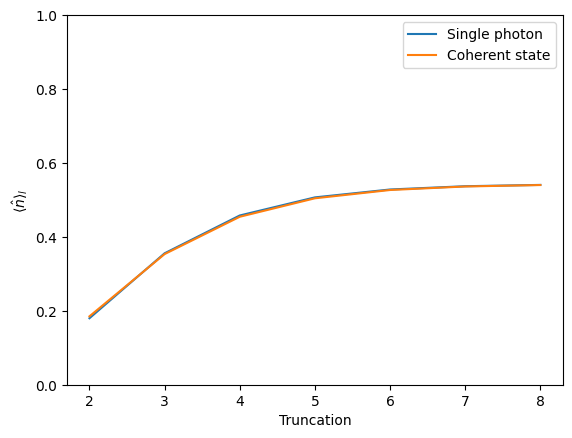

In [17]:
plt.plot(truncation, single[:,1], label = 'Single photon')
plt.plot(truncation, coherent[:,1], label = 'Coherent state')
plt.legend()
plt.ylabel(r"$\langle \hat{n} \rangle_l$")
plt.xlabel("Truncation")
plt.ylim(0,1)
